# Applying LIME on same dataset to different ML models

## Local Interpretable Model-agnostic Explanations

## Import Libraries

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
import shap

In [38]:
import os
os.chdir('/Users/sylvia/Desktop/Datasets')

df = pd.read_csv("stroke-data.csv")
len(df)

5110

In [39]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Data Preprocessing

In [40]:
# Drop irrelevant columns
df_copy = df.copy()
df = df.drop('id', axis=1)
type(df)

pandas.core.frame.DataFrame

In [41]:
# Check null values
print(df.isnull().sum())

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


In [42]:
# Remove 201 people with missing bmi values
df1 = df.dropna()
df1 = df1.reset_index()
len(df1)
print(df1.isnull().sum())

index                0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


In [43]:
# Encode Categorical columns
df1.dtypes
# all object data types is categorical columns

index                  int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [44]:
pd.unique(df1[['gender', 'ever_married','work_type', 'Residence_type','smoking_status']].values.ravel('k'))

array(['Male', 'Female', 'Other', 'Yes', 'No', 'Private', 'Self-employed',
       'Govt_job', 'children', 'Never_worked', 'Urban', 'Rural',
       'formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

In [45]:
df1.head(10)

,index,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,5,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
5,6,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
6,7,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
7,9,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1
8,10,Female,81.0,1,0,Yes,Private,Rural,80.43,29.7,never smoked,1
9,11,Female,61.0,0,1,Yes,Govt_job,Rural,120.46,36.8,smokes,1


In [46]:
df2 = df1.drop(['index'],axis=1)
df2.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [47]:
# One Hot encoding categorical variables

# Import
from sklearn.preprocessing import OneHotEncoder

# Instantiate
encoder = OneHotEncoder(handle_unknown='ignore')

# Perform one-hot encoding on 'gender', 'ever_married','work_type', 'Residence_type','smoking_status'
# 1 is encoded where value is present
cat_column_list = ['gender','ever_married','work_type', 'Residence_type','smoking_status']

encoder_df = pd.DataFrame(encoder.fit_transform(df1[cat_column_list]).toarray())
encoder_df.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
6,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
8,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
9,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [48]:
# rename columns
encoder_df.columns = ['0-female', '1-male', '2-other', '3-not-married', '4-married', '5-govt-job','6-never-worked','7-private','8-self_employed','9-children','10-rural','11-urban','12-smoke-unknown','13-formaly-smoked','14-never-smoked','15-smoked']
print(encoder_df.head())
print(encoder_df.isnull().sum())

   0-female  1-male  2-other  3-not-married  4-married  5-govt-job  \
0       0.0     1.0      0.0            0.0        1.0         0.0   
1       0.0     1.0      0.0            0.0        1.0         0.0   
2       1.0     0.0      0.0            0.0        1.0         0.0   
3       1.0     0.0      0.0            0.0        1.0         0.0   
4       0.0     1.0      0.0            0.0        1.0         0.0   

   6-never-worked  7-private  8-self_employed  9-children  10-rural  11-urban  \
0             0.0        1.0              0.0         0.0       0.0       1.0   
1             0.0        1.0              0.0         0.0       1.0       0.0   
2             0.0        1.0              0.0         0.0       0.0       1.0   
3             0.0        0.0              1.0         0.0       1.0       0.0   
4             0.0        1.0              0.0         0.0       0.0       1.0   

   12-smoke-unknown  13-formaly-smoked  14-never-smoked  15-smoked  
0               0.0    

In [49]:
print(df2.isnull().sum())

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


In [50]:
# Remove encoded col's ['gender','ever_married','work_type', 'Residence_type','smoking_status']
# from original df
df2.drop(['gender','ever_married','work_type', 'Residence_type','smoking_status'],axis=1,inplace=True)
df2.columns

Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'stroke'],
      dtype='object')

In [51]:
print(encoder_df.shape)
print(df2.shape)

(4909, 16)
(4909, 6)


In [52]:
print(encoder_df.head())
print(df2.head())

   0-female  1-male  2-other  3-not-married  4-married  5-govt-job  \
0       0.0     1.0      0.0            0.0        1.0         0.0   
1       0.0     1.0      0.0            0.0        1.0         0.0   
2       1.0     0.0      0.0            0.0        1.0         0.0   
3       1.0     0.0      0.0            0.0        1.0         0.0   
4       0.0     1.0      0.0            0.0        1.0         0.0   

   6-never-worked  7-private  8-self_employed  9-children  10-rural  11-urban  \
0             0.0        1.0              0.0         0.0       0.0       1.0   
1             0.0        1.0              0.0         0.0       1.0       0.0   
2             0.0        1.0              0.0         0.0       0.0       1.0   
3             0.0        0.0              1.0         0.0       1.0       0.0   
4             0.0        1.0              0.0         0.0       0.0       1.0   

   12-smoke-unknown  13-formaly-smoked  14-never-smoked  15-smoked  
0               0.0    

In [53]:
# Now final_df = encoder_df + df1
df_final = pd.concat([encoder_df, df2], axis=1)
print(df_final.isnull().sum())
print(df_final.head())

0-female             0
1-male               0
2-other              0
3-not-married        0
4-married            0
5-govt-job           0
6-never-worked       0
7-private            0
8-self_employed      0
9-children           0
10-rural             0
11-urban             0
12-smoke-unknown     0
13-formaly-smoked    0
14-never-smoked      0
15-smoked            0
age                  0
hypertension         0
heart_disease        0
avg_glucose_level    0
bmi                  0
stroke               0
dtype: int64
   0-female  1-male  2-other  3-not-married  4-married  5-govt-job  \
0       0.0     1.0      0.0            0.0        1.0         0.0   
1       0.0     1.0      0.0            0.0        1.0         0.0   
2       1.0     0.0      0.0            0.0        1.0         0.0   
3       1.0     0.0      0.0            0.0        1.0         0.0   
4       0.0     1.0      0.0            0.0        1.0         0.0   

   6-never-worked  7-private  8-self_employed  9-children  .

In [54]:
df_features = df_final.copy()
df_features.drop('stroke',axis=1,inplace=True)
df_features

,0-female,1-male,2-other,3-not-married,4-married,5-govt-job,6-never-worked,7-private,8-self_employed,9-children,...,11-urban,12-smoke-unknown,13-formaly-smoked,14-never-smoked,15-smoked,age,hypertension,heart_disease,avg_glucose_level,bmi
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,67.0,0,1,228.69,36.6
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,80.0,0,1,105.92,32.5
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,49.0,0,0,171.23,34.4
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,79.0,1,0,174.12,24.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,81.0,0,0,186.21,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4904,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,13.0,0,0,103.08,18.6
4905,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,81.0,0,0,125.20,40.0
4906,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,35.0,0,0,82.99,30.6
4907,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,51.0,0,0,166.29,25.6


In [55]:
# Correlation plot - All columns should be numerical to calculate pearson
# correlation coefficient
corr = df_final.corr()
corr

,0-female,1-male,2-other,3-not-married,4-married,5-govt-job,6-never-worked,7-private,8-self_employed,9-children,...,12-smoke-unknown,13-formaly-smoked,14-never-smoked,15-smoked,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0-female,1.000000,-0.999579,-0.017128,-0.036703,0.036703,0.015123,-0.012297,0.038611,0.022312,-0.091619,...,-0.057893,-0.039592,0.094051,-0.011519,0.030457,-0.021730,-0.082882,-0.053358,0.026360,-0.006851
1-male,-0.999579,1.000000,-0.011891,0.036138,-0.036138,-0.014965,0.012326,-0.038972,-0.022134,0.091791,...,0.058170,0.038681,-0.093736,0.011694,-0.030149,0.021863,0.082983,0.053008,-0.026020,0.006939
2-other,-0.017128,-0.011891,1.000000,0.019567,-0.019567,-0.005477,-0.000958,0.012332,-0.006180,-0.005680,...,-0.009391,0.031484,-0.011110,-0.005999,-0.010674,-0.004540,-0.003257,0.012219,-0.011802,-0.003010
3-not-married,-0.036703,0.036138,0.019567,1.000000,-1.000000,-0.137915,0.091976,-0.156818,-0.191469,0.545462,...,0.338169,-0.176007,-0.105253,-0.106574,-0.680782,-0.162406,-0.111245,-0.151377,-0.341695,-0.105089
4-married,0.036703,-0.036138,-0.019567,-1.000000,1.000000,0.137915,-0.091976,0.156818,0.191469,-0.545462,...,-0.338169,0.176007,0.105253,0.106574,0.680782,0.162406,0.111245,0.151377,0.341695,0.105089
5-govt-job,0.015123,-0.014965,-0.005477,-0.137915,0.137915,1.000000,-0.025745,-0.444147,-0.166136,-0.152679,...,-0.098583,0.030095,0.046898,0.031402,0.133593,0.019232,0.005095,0.017723,0.079584,0.003553
6-never-worked,-0.012297,0.012326,-0.000958,0.091976,-0.091976,-0.025745,1.000000,-0.077664,-0.029051,-0.026698,...,0.008992,-0.030419,0.035866,-0.028200,-0.079384,-0.021341,-0.015312,-0.013991,-0.028602,-0.014149
7-private,0.038611,-0.038972,0.012332,-0.156818,0.156818,-0.444147,-0.077664,1.000000,-0.501179,-0.460584,...,-0.214513,0.024872,0.110871,0.099115,0.120021,-0.004637,-0.000279,0.009273,0.208029,0.014934
8-self_employed,0.022312,-0.022134,-0.006180,-0.191469,0.191469,-0.166136,-0.029051,-0.501179,1.000000,-0.172285,...,-0.107225,0.096354,0.029529,-0.003680,0.327347,0.111794,0.081484,0.069051,0.072701,0.055356
9-children,-0.091619,0.091791,-0.005680,0.545462,-0.545462,-0.152679,-0.026698,-0.460584,-0.172285,1.000000,...,0.516968,-0.161479,-0.243643,-0.163921,-0.634937,-0.126561,-0.088072,-0.101182,-0.448674,-0.080971


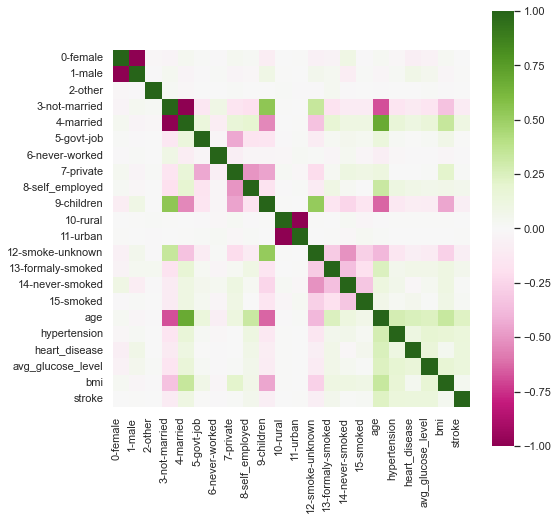

In [56]:
# Plot correlation heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Plot these values on heatmap

sns.set(style = 'whitegrid')
sns.set_palette('bright')

f,ax = plt.subplots(figsize=(8,8))
sns.heatmap(corr,
            vmin=-1, vmax=1, center=0,
            cmap='PiYG',
            square=True,
            ax=ax)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right');

In [57]:
# Split data into target & features
from sklearn.model_selection import train_test_split
X = df_final.iloc[:,:-1]
y = df_final.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2022)

In [58]:
# Oversampling minority class
# Before oversampling
print(X_train.shape)
print(y_train.shape)
print(y_train.value_counts())

(3927, 21)
(3927,)
0    3759
1     168
Name: stroke, dtype: int64


In [59]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [60]:
# After oversampling
print(X_train.shape)
print(y_train.shape)
print(y_train.value_counts())

(7518, 21)
(7518,)
0    3759
1    3759
Name: stroke, dtype: int64


In [61]:
print(type(X_train))
print(type(y_train))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [62]:
X_train.head()

,0-female,1-male,2-other,3-not-married,4-married,5-govt-job,6-never-worked,7-private,8-self_employed,9-children,...,11-urban,12-smoke-unknown,13-formaly-smoked,14-never-smoked,15-smoked,age,hypertension,heart_disease,avg_glucose_level,bmi
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,51.0,0,0,219.96,42.3
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,33.0,0,0,105.19,50.1
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,1.4,0,0,129.07,20.6
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,5.0,0,0,92.23,16.7
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,80.0,0,1,125.32,32.9


In [63]:
y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: stroke, dtype: int64

# Model 1 - Logistic Regression

In [64]:
from sklearn.linear_model import LogisticRegression

lr_classifier = LogisticRegression(random_state=2022, max_iter=500)

lr_classifier.fit(X_train, y_train)

# Predict
y_pred = lr_classifier.predict(X_test)

In [65]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average = 'macro')
recall = recall_score(y_test, y_pred, average = 'macro')
f1 = f1_score(y_test, y_pred, average = 'macro')
#
print("acc", acc)
print("precision", precision)
print("recall", recall)
print("f1", f1)

acc 0.7556008146639511
precision 0.5503078656605628
recall 0.7441745937119307
f1 0.5278846153846154


## LIME Explainer for Logistic Regression

In [72]:
# Import
from interpret.blackbox import LimeTabular
from interpret import show

# Instantiate
lime = LimeTabular(predict_fn=lr_classifier.predict,
                   data=X_train,
                   random_state=2022)

X does not have valid feature names, but LogisticRegression was fitted with feature names


In [79]:
# Get Local Explanations - 20 examples for 20 simple models will be created.
# It will choose last 3 instances. Step size not given so default +1 hence move
# from Left to Right until end so -3,-2,-1 i.e. 3 instances will be selected!

lime_local = lime.explain_local(X_test[5:6],
                                y_test[5:6],
                                name='LIME')

show(lime_local)

/Users/sylvia/opt/anaconda3/envs/TF1/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names

/Users/sylvia/opt/anaconda3/envs/TF1/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names



<!-- http://127.0.0.1:7001/140465306841232/ -->